### 1. Parse Available Datasets:

In [15]:
import requests
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from tabulate import tabulate
import re


In [10]:
#################################################################################################
# Defining the function necessary to connect with the API and exract the basic data of the works.
#################################################################################################

def fetch_all_works(title_query):
    # create empty works list
    works = []

    # Impose pagination to ensure that if future books that are added, they are not missed due to a server imposed extraction limits.
    # This also circumvents the default limit of 100 extracted objects.

    start = 0
    limit = 100

    substring = title_query

    # Use q=title%3A+ instead of title=
    # API page: https://openlibrary.org/dev/docs/api/search, suggests that title= should be used as the query, however this seems to return fewer items
    # than the when the query is used in the title field of the website.

    while True:

        # 'search.json?' is added to provide access to the json file, which forms the basis of data extraction.
        # title_query is the item that is entered into the title search-field only.
        # Spaces in the title_query are reformatted appropriately.
        # Pagination is imposed using limit and offset (previously defined).

        url = f"https://openlibrary.org/search.json?q=title%3A+{title_query.replace(' ', '+')}&limit={limit}&offset={start}"

        try:
            response = requests.get(url)

            # Raises error if the connection to the API is compromised, alerting the user.
            response.raise_for_status()

            # Data is retrieved in the form of json.
            data = response.json()

            # docs represents a list of works (which are dictionaries containing their attributes) extracted from the json file.
            # An empty list is returned when handling 'None'.
            docs = data.get('docs', [])

            # This breaks the pagination loop when the list of works (docs) is empty (i.e. every book has been extracted).
            if not docs:
                break

            # Each work is structured as a dictionary of its attributes, which is, in turn, extracted from the original doc dictionary (individual books).
            for doc in docs:
                work = {
                    'title': doc.get('title'),
                    'author_name': doc.get('author_name', []),
                    'first_publish_year': doc.get('first_publish_year'),
                    'isbn': doc.get('isbn', []),
                    'key': doc.get('key')
                }

                if substring.lower() in work['title'].lower():
                  # This checks that the extracted data actually fits the critera of the query (it is designed to not be case-sensitive).
                  works.append(work)

            # This ensures that successive 100 groups of works are analysed.
            start += limit

        # This informs the user of an API connection error
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break

    # The list of work dictionaries is transformed into a pandas dataframe, with attributes forming column headers.
    return pd.DataFrame(works)

title_query = 'lord of the rings'

fetch_all_works(title_query)
# The Open Library API limits the number of results returned per request to 100 to optimize performance and reduce server load. Therefore the fetching has to done over several steps.
# Year is returned as a float.
# Query appears to return 677 items, when the website displays 604 items when the title field is queried with 'lord of the rings'.
# There appear to be some anomalies returned before the original lord of the rings release in 1954.
# Decided to impose stricter conditions on the book title name, returning c.400 items


,title,author_name,first_publish_year,isbn,key
0,The Lord of the Rings,[J.R.R. Tolkien],1954.0,"[3608939849, 0898452236, 0048230464, 226612745...",/works/OL27448W
1,Novels (Hobbit / Lord of the Rings),[J.R.R. Tolkien],1979.0,"[9781565117075, 9780395282632, 0008112835, 000...",/works/OL14926019W
2,Lord of the Rings,[Cedco Publishing],2001.0,"[9780768325232, 0768325234, 9780768325782, 978...",/works/OL8527426W
3,The lord of the rings,[Brian Sibley],2001.0,"[0618260226, 9781417605101, 0618195599, 061825...",/works/OL3062799W
4,Lord of the rings,[Jim Pendrill],NaN,[],/works/OL12413029W
...,...,...,...,...,...
394,The Lord of the Rings THREE VOLUMES IN ONE (Th...,[n/a],1971.0,[],/works/OL31371103W
395,Tolkien English Glossary A Guide to Old Uncomm...,[Oliver Loo],2010.0,"[9780557255788, 0557255783]",/works/OL29003237W
396,Tongariro National Park Trekking/Hiking/Walkin...,[Sergio Mazitto],2018.0,"[9781983588327, 1983588326]",/works/OL20541537W
397,The Real Middle Earth: Exploring the Magic and...,[Brian Bates],2015.0,"[1466891092, 9781466891098]",/works/OL19863436W


In [49]:
################################################################################
# Defining the functions necessary to display the publication frequency history.
################################################################################

def fetch_sort_freq(title_query):

  df = fetch_all_works(title_query)
  df_sorted = df.sort_values(by='first_publish_year')

  # Preparation of publication year analysis.
  publish_years = df['first_publish_year']

  # Remove items that have no meaningful attribute assigned for year.
  publish_years_clean = publish_years.dropna()

  count = publish_years_clean.value_counts()

  # Convert the result to a dictionary for convenience.
  frequency_dict = count.to_dict()

  return frequency_dict, title_query

def plot_frequency(frequency_dict, title_query, film_rel_years):
  present_year = 2024

  # Extract keys and values from the dictionary (i.e. years and publication counts).
  numbers = list(frequency_dict.keys())
  frequencies = list(frequency_dict.values())

  # Sort the keys and corresponding frequencies for better plotting.
  sorted_indices = sorted(range(len(numbers)), key=lambda i: numbers[i])
  numbers = [numbers[i] for i in sorted_indices]
  frequencies = [frequencies[i] for i in sorted_indices]

  # Data provided for the Lord of the Rings trilogy film release.
  # Hypothesised that this will have affected publication rate.
  # film_rel_years = [2001, 2002, 2003]

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.bar(numbers, frequencies, color='skyblue')
  plt.xlabel('Year')

  # Removes anomalies published in the future.
  plt.xlim([numbers[0], present_year])

  plt.ylabel('Number of publications')
  plt.title('Frequency of publications with titles containing `' + str(title_query) + '\'')
  # plt.xticks(numbers)

  # Plots vertical lines denoting significant events that may have affected publication.
  plt.axvline(x=film_rel_years[0], color='b', linestyle='--', linewidth=1, label = 'film release')
  for n in range(1, len(film_rel_years)):
    plt.axvline(x=film_rel_years[n], color='b', linestyle='--', linewidth=1)

  plt.axvline(x=2020, color='r', linestyle='--', linewidth=1, label = 'covid-19')
  #plt.axvline(x=1954, color='g', linestyle='--', linewidth=2, label = 'original release')

  plt.legend()
  plt.grid()
  plt.show()

  return

### 1(.1) Interesting Extra

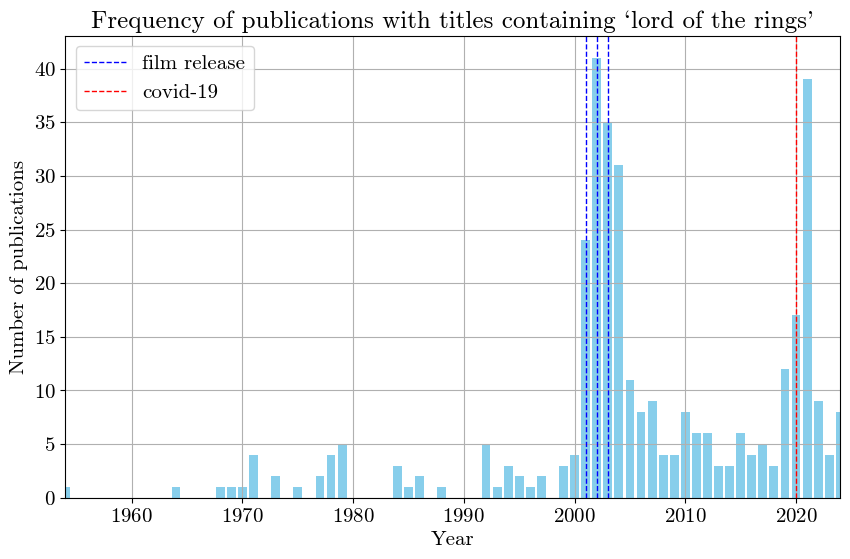

FileNotFoundError: [Errno 2] No such file or directory: 'internet_rise.jpeg'

In [50]:
###################################
# Plotting publication year history
###################################

# Chose latex-esque font.
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['font.size'] = 15

title_query = "lord of the rings"

lr_freq_dict = fetch_sort_freq(title_query)

plot_frequency(lr_freq_dict[0], lr_freq_dict[1], [2001, 2002, 2003])

img = mpimg.imread('internet_rise.jpeg')

# Display the image
plt.figure(figsize=(14, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()



## Some Thoughts:

1. As is logical, all releases with titles containing 'lord of the rings' were released after the initial publication by J.R.R Tolkien in 1954.

2. Between 1954 and 1997, there were few further publications containing 'lord of the rings' in the title.

3. The first figure shows dotted lines denoting the year of the Lord of Rings trilogy film releases. I would hypothesise that due to the global success of the films, a larger number of people were made aware of the trilogy. This may have resulted in a array of additional works (for example: reviews or spin-offs).

4. To compound this growth in publication frequency around the turn of the millenium, the internet was becoming rapidly widespread. Looking at the second figure (from https://www.statista.com/chart/2007/internet-adoption-in-the-us/), which tracks the percentage of internet users in America and I have decided to use as a yardstick for the developed world, we see that two thirds of adults are using the internet by 2005 (almost a 5-fold increase from 1995). I have also hypothesised that the relative ease of ebook exclusive publication has driven the growth in the period.

5. Lastly, we see a drastic peak in publication in 2021, which was deep into the pandemic-imposed lockdowns globally. I hypothesise that this will have increased the rate of publication of works (specifically ebooks) containing 'containing lord of the rings', driven by both a surge in creativity in this online space as well as an increased viewership demand.



### 2. Retrieve a Specific Dataset:

In [13]:
#######################################################################################################
# Defining a new function to connect to the API and extract edition information in an efficient manner.
#######################################################################################################

def fetch_all_editions(title_query):
    # Create an empty list to store book data
    works = []

    # Pagination settings
    start = 0
    limit = 100

    while True:
        # Construct the API URL with pagination that returns the 'editions' objct within the 'docs' objects.
        url = f"https://openlibrary.org/search.json?q=title%3A+{title_query.replace(' ', '+')}&fields=key,title,author_name,editions&limit={limit}&offset={start}"

        try:
            response = requests.get(url)
            response.raise_for_status()  # Check for request errors
            data = response.json()

            docs = data.get('docs', [])

            # Exit loop if no more books are returned
            if not docs:
                break

            # Process each book document
            for doc in docs:
                # Edition attributes are nested.
                # Edition should return an empty dictionary object if None is given.
                edition_count = doc.get('editions', {}).get('numFound', 0)
                work = {
                    'title': doc.get('title'),
                    'author_name': doc.get('author_name', []),
                    'edition_count': edition_count
                }

                works.append(work)

            # Update start for the next batch for extraction.
            start += limit

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(works)

### 3. Brief Data Exploration

In [21]:
###############################################################################################################################
# Chosen to query title once again with 'harry potter and the'; taking a look at the works with the greatest number of editions.
# Looking to tabulate the top 10.
################################################################################################################################

title_query2 = 'harry potter and the'
hp_df = fetch_all_editions(title_query2)
top10 = hp_df.sort_values(by='edition_count', ascending=False).head(10)

# There are 7 books in the original series.
originals = top10.head(7)

+---------------------------------------------------------+-----------------------------------------------------------------------------------------+-----------------+
| title                                                   | author_name                                                                             |   edition_count |
|---------------------------------------------------------+-----------------------------------------------------------------------------------------+-----------------|
| Harry Potter and the Philosopher's Stone                | ['J. K. Rowling']                                                                       |             315 |
| Harry Potter and the Chamber of Secrets                 | ['J. K. Rowling']                                                                       |             261 |
| Harry Potter and the Prisoner of Azkaban                | ['J. K. Rowling']                                                                       |           

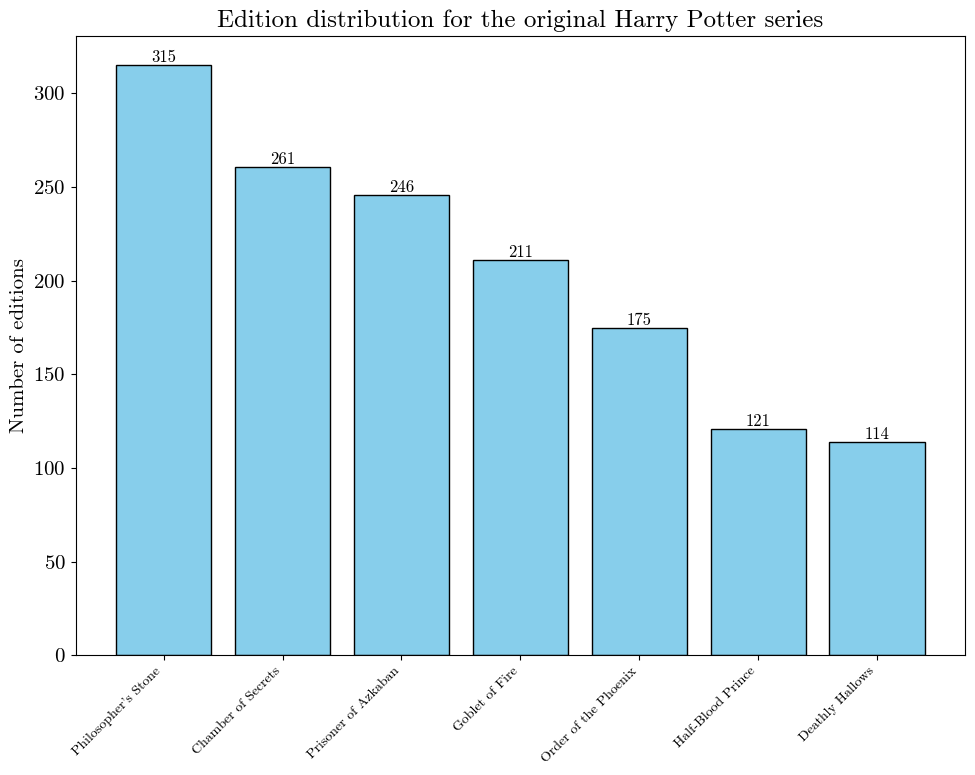

In [22]:
# Tabulte the 10 titles and corresponding author names for the top 10, based on number of editions.
table = tabulate(top10, headers='keys', tablefmt='psql', showindex=False)
print(table)

or_book_titles = originals['title']
edition_counts = originals['edition_count']

trunc_titles = []

# For better plot formatting, truncate the book names of the original series.
for title in or_book_titles:
  trunc_titles.append(re.sub("Harry Potter and the ", "", title))


# Create a histogram (bar plot)
plt.figure(figsize=(10, 8))
bars = plt.bar(trunc_titles, edition_counts, color='skyblue', edgecolor='black')

# Add labels to each bar
for bar in bars:
    height = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.title('Edition distribution for the original Harry Potter series')
plt.ylabel('Number of editions')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


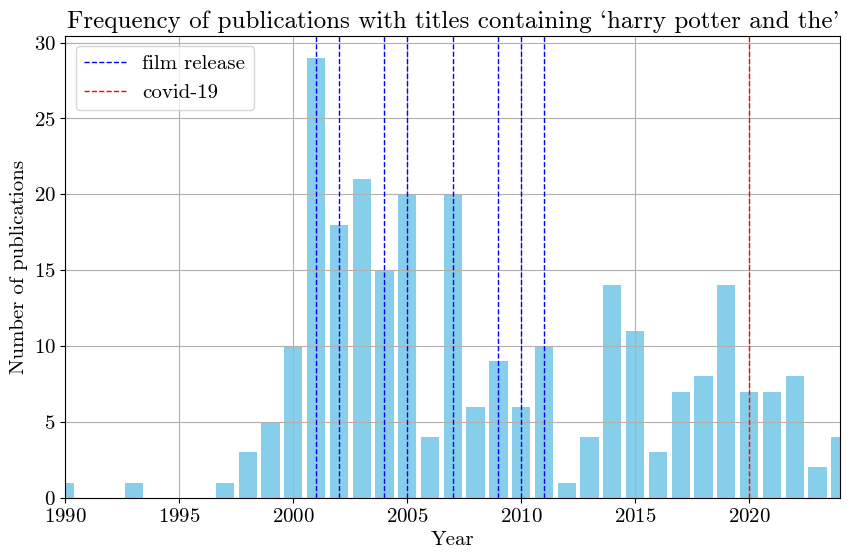

In [51]:
hp_film_releases = [2001, 2002, 2004, 2005, 2007, 2009, 2010, 2011]

hp_freq_dict = fetch_sort_freq(title_query2)
plot_frequency(hp_freq_dict[0], hp_freq_dict[1], hp_film_releases)

Total number of works containing 'harry potter and the': 590
Total number of works by author, J. K. Rowling': 94
Most frequent authors:
J. K. Rowling: 94
John Williams: 20
Jody Revenson: 19
Insight Editions: 17
British Broadcasting Corporation Staff: 8


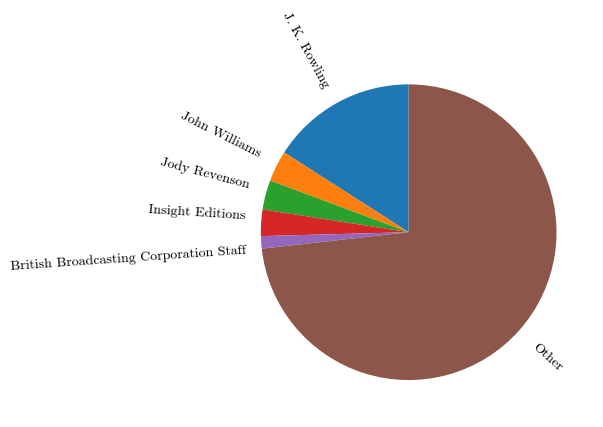

In [42]:
##############################################################
# Pie chart, displaying the top 5 authors in terms of editions.
##############################################################

total_works = hp_df.shape[0]
print('Total number of works containing \'' + str(title_query2) + '\': ' + str(total_works))

total_jk = hp_df.loc[hp_df['author_name'].apply(lambda authors: 'J. K. Rowling' in authors)]

print('Total number of works by author, ' + 'J. K. Rowling' + '\': ' + str(total_jk.shape[0]))

all_authors = [author for authors in hp_df['author_name'] for author in authors]

# Count the occurrences of each author
author_counts = Counter(all_authors)

# Identify the most frequent authors
most_com_num = 5
most_common_authors = author_counts.most_common(most_com_num)  # Get the top 10 most frequent authors

# Display the most frequent authors
print("Most frequent authors:")
for author, count in most_common_authors:
    print(f"{author}: {count}")


labels, sizes = zip(*most_common_authors)

labels_all = labels + ('Other',)

t5_tot = sum(sizes)

sizes_all = sizes + ((hp_df.shape[0]- t5_tot),)

plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 10

plt.pie(sizes_all, labels=labels_all, labeldistance=1.1, rotatelabels=True, startangle=90)
plt.show()

### Some Thoughts:

1. The 7 books of the original Harry Potter series are, unsurprisingly, the books with the greatest number of editions.

2. The number of editions are also in order of release. Which can be explained by increasing book complexity and a shorter time period on the market.

3. Number of editions does not sufficent to confirm overall popularity. One would assume, however, that a successful book will be published with more editions and in more languagesshowing a global reach.

4. The query returned a couple of books that were supposidly published before 'Harry Potter and the Philosopher's Stone' was released, highlighting an anomally or potential error.

5. The films were released at such a consatnt rate between 2001 - 2011, that it is difficult to deduce any causation between film release and publication. The lead time between film release and publication of any supplementary works would be worth investigating.

6. The pandemic appears to have had no marked affect on publication rate.

### Notes:
1. When performing the basic query, there were discrepancies between the number of items returns by the API and the manual query on the website itself.

2. Would do OOP to tidy format and improve scalability.